# 3.1 Classification with a single-layer perceptron

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1000)
from mlxtend.plotting import plot_decision_regions

## 3.1.1 Generation of linearly-separable data

In [2]:
n = 100
mA = [1,0.5]
sigmaA=0.5
mB = [-1,0]
sigmaB = 0.5
cov = np.eye(2)
classA = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,n)
classB = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,n)

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0],dtype=int), -np.ones(classB.shape[0],dtype=int)))
N = inputs.shape[0]  # Number of rows (samples)
permute = list(range(N))
np.random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

## 3.1.2 Classification with a single-layer perceptron and analysis

### question 1
Apply and compare perceptron learning with the Delta learning rule in batch mode on the generated dataset. Adjust the learning rate and study the convergence of the two algorithms.

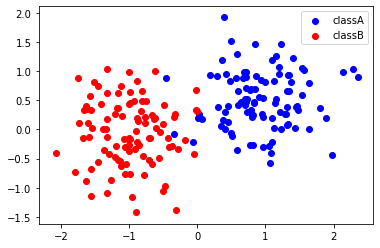

In [3]:
# show the data
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c='blue', label='classA')
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c='red', label='classB')
plt.legend()
plt.show()

### Perceptron

In [4]:
class Perceptron(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs

    def train(self, X, y):

        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

* boundary

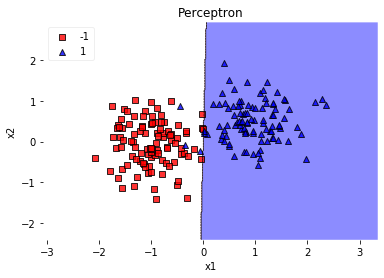

In [5]:
X = inputs
y = targets
EPOCH =20
eta=0.01
ppn = Perceptron(epochs=EPOCH, eta=eta)
ppn.train(X, y)
plot_decision_regions(X, y, clf=ppn,legend=2,colors='red,blue')
plt.title('Perceptron')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/perceptron_boundary_eta{}.png'.format(str(eta)))
plt.show()

* converge

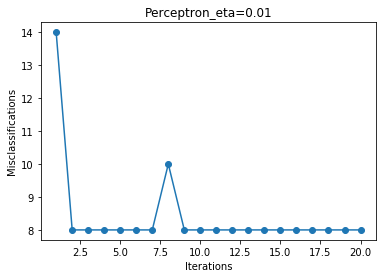

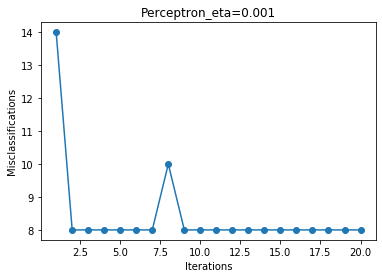

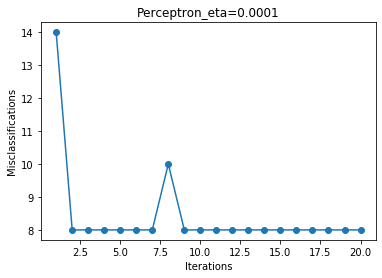

In [6]:
for eta in [0.01,0.001,0.0001]:
    ppn = Perceptron(epochs=EPOCH, eta=eta)
    ppn.train(X, y)
    plt.plot(range(1, len(ppn.errors_)+1), ppn.errors_, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Misclassifications')
    plt.title("Perceptron_eta="+str(eta))
    plt.savefig('imgs/perceptron_converge_eta{}.png'.format(str(eta)))
    plt.show()

### Delta rule (GD)

In [7]:
class AdalineGD(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs

    def train(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.epochs):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

* diverge and converge

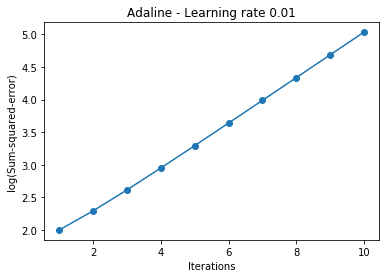

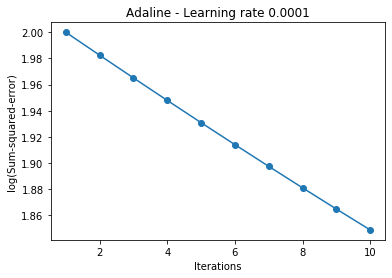

In [8]:
for eta in [0.01,0.0001]:
    ada = AdalineGD(epochs=10, eta=eta).train(X, y)
    plt.plot(range(1, len(ada.cost_)+1), np.log10(ada.cost_), marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('log(Sum-squared-error)')
    plt.title('Adaline - Learning rate {}'.format(str(eta)))
    plt.savefig('imgs/delta_effect_eta{}.png'.format(str(eta)))
    plt.show()

* boundary

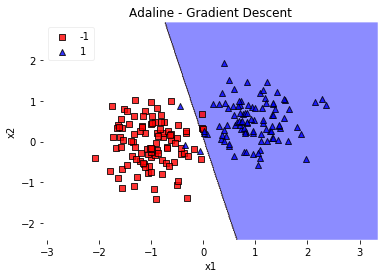

In [9]:
ada = AdalineGD(epochs=20, eta=0.001)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_boundary_eta{}.png'.format(str(eta)))
plt.show()


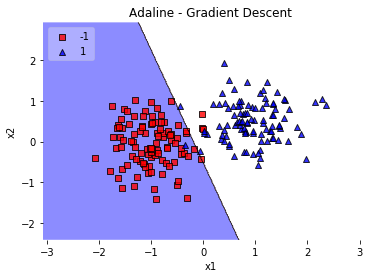

In [10]:
ada = AdalineGD(epochs=20, eta=0.01)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_boundary_eta{}.png'.format(str(eta)))
plt.show()

* converge compare

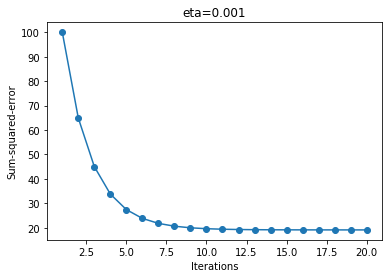

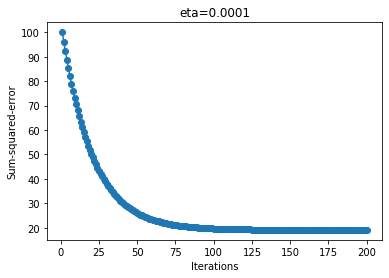

In [11]:
for eta in [0.001,0.0001]:
    ada = AdalineGD(epochs=int(20*0.001/eta), eta=eta)
    ada.train(X, y)
    plt.plot(range(1, len( ada.cost_)+1), ada.cost_, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Sum-squared-error')
    plt.title('eta={}'.format(str(eta)))
    plt.savefig('imgs/delta_convergence_eta{}.png'.format(str(eta)))
    plt.show()
    

### question 2
Compare sequential with a batch learning approach for the Delta rule. How quickly (in terms of epochs) do the algorithms
converge? Please adjust the learning rate and plot the learning curves for each variant. Bear in mind that for 
sequential learning you should not use the matrix form of the learning rule discussed in section 2.2 and instead perform
 updates iteratively for each sample. How sensitive is learning to random initialisation?

* sequential

In [12]:
class AdalineGD_sequential(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = 0

    def train(self, X, y):
        # no reinitials
        
        for i in range(self.epochs):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost=cost
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)


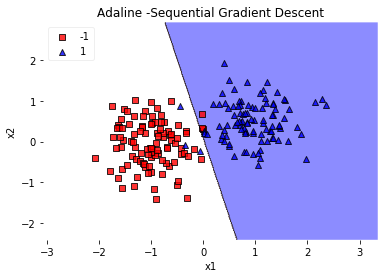

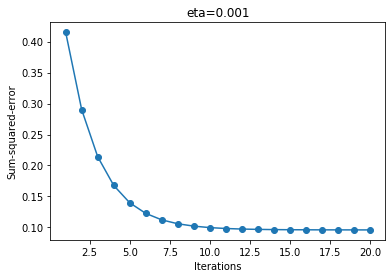

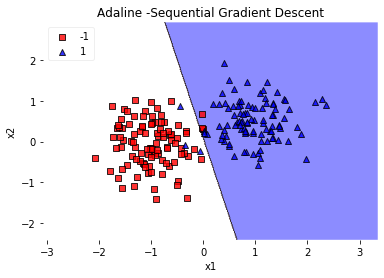

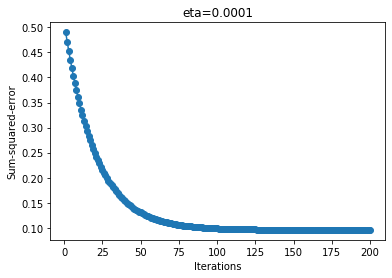

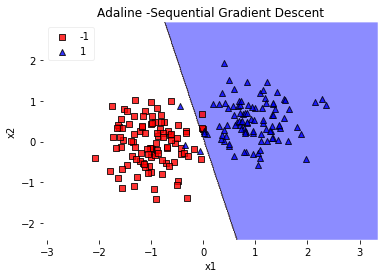

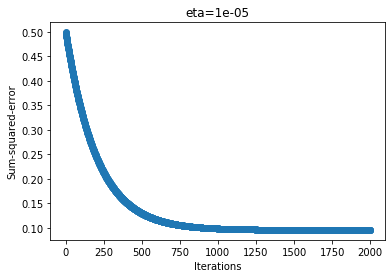

In [13]:
for eta in [0.001,0.0001,0.00001]:
    ada = AdalineGD_sequential(eta=eta,epochs=1)
    epochs = int(20*0.001/eta)
    costs = []
    for epoch in range(epochs):
        cost=[]
        #shuffle
        permute = list(range(N))
        np.random.shuffle(permute)
        X = X[permute, :]
        y = y[permute]
        #train
        for ri in range(N):
            ada.train(X[ri].reshape(1,2),y[ri])
            cost.append(ada.cost)
        costs.append(np.mean(cost))   
    plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
    plt.title('Adaline -Sequential Gradient Descent')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.savefig('imgs/sequential_boundary_eta{}.png'.format(str(eta)))
    plt.show()
    plt.plot(range(1, epochs+1), costs, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Sum-squared-error')
    plt.title('eta={}'.format(str(eta)))
    plt.savefig('imgs/sequential_eta{}.png'.format(str(eta)))
    plt.show()

### question 3
Remove the bias, train your network with the Delta rule in batch mode and test its behaviour. In what cases would the perceptron without bias converge and classify correctly all data samples? Please verify your hypothesis by adjusting data parameters, mA and mB.

In [14]:
class AdalineGD_unbiased(object):

    def __init__(self, eta=0.01, epochs=50):
        self.eta = eta
        self.epochs = epochs

    def train(self, X, y):
        self.w_ = np.zeros( X.shape[1])
        self.cost_ = []

        for i in range(self.epochs):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * X.T.dot(errors)
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_)

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)



* different side of (0,0)

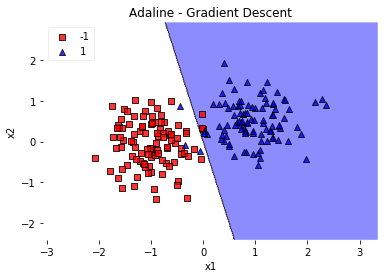

In [15]:
ada = AdalineGD_unbiased(epochs=20, eta=0.001)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_unbiased_eta{}.png'.format(str(eta)))
plt.show()

* same side of (0,0)

In [16]:
mA = [1,1]
sigmaA=0.5
mB = [2,2]
sigmaB = 0.5
cov = np.eye(2)
classA = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,n)
classB = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,n)

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0],dtype=int), -np.ones(classB.shape[0],dtype=int)))
N = inputs.shape[0]  # Number of rows (samples)
permute = list(range(N))
np.random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

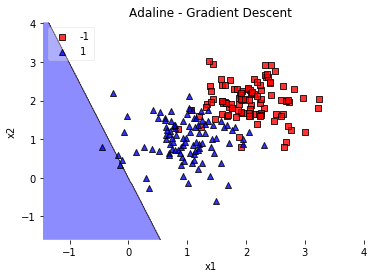

In [17]:
X = inputs
y = targets
ada = AdalineGD_unbiased(epochs=20, eta=0.001)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_unbiased_eta{}.png'.format(str(eta)))
plt.show()

## 3.1.3 Classification of samples that are not linearly separable

### overlap

In [30]:
mA = [1,1]
sigmaA = 0.5
mB = [1.8,1.8]
sigmaB = 0.5
cov = np.eye(2)
classA = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,n)
classB = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,n)

inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0],dtype=int), -np.ones(classB.shape[0],dtype=int)))
N = inputs.shape[0]  # Number of rows (samples)
permute = list(range(N))
np.random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

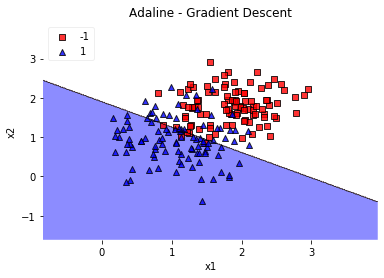

In [31]:
X=inputs
y=targets

ada = AdalineGD(epochs=20, eta=0.001)
ada.train(X, y)
plot_decision_regions(X, y, clf=ada,legend=2,colors='red,blue')
plt.title('Adaline - Gradient Descent')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/delta_overlap_eta{}.png'.format(str(eta)))
plt.show()

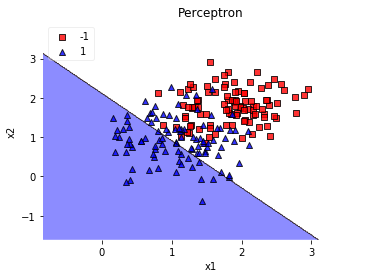

In [32]:
ppn = Perceptron(epochs=EPOCH, eta=eta)
ppn.train(X, y)
plot_decision_regions(X, y, clf=ppn,legend=2,colors='red,blue')
plt.title('Perceptron')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('imgs/perceptron_overlap_eta{}.png'.format(str(eta)))
plt.show()

In [ ]:
### Linearly non-separable dataset

In [34]:
mA = [1,0.3]
sigmaA=0.2
mB = [0,-0.1]
sigmaB = 0.3
cov = np.eye(2)
classA1 = np.random.multivariate_normal(mA,sigmaA*sigmaA*cov,50)
classA2 = np.random.multivariate_normal([-1,0.3],sigmaA*sigmaA*cov,50)
classA = np.concatenate((classA1,classA2))
classB = np.random.multivariate_normal(mB,sigmaB*sigmaB*cov,n)
inputs = np.concatenate((classA, classB))
targets = np.concatenate((np.ones(classA.shape[0],dtype=int), -np.ones(classB.shape[0],dtype=int)))
N = inputs.shape[0]  # Number of rows (samples)
permute = list(range(N))
np.random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

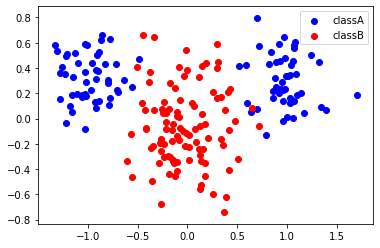

In [35]:
# show the data
plt.scatter([p[0] for p in classA], [p[1] for p in classA], c='blue', label='classA')
plt.scatter([p[0] for p in classB], [p[1] for p in classB], c='red', label='classB')
plt.legend()
plt.show()


* random 25% from each class